In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.colors import Normalize
import matplotlib.cm as cm
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" 
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
set_seed(42)


In [2]:
def f(x):
    pi = torch.pi
    return ((0.1*pi)**2 * torch.sin(0.1*pi*x) +
            (pi)**2 * 0.2 * torch.sin(pi*x) +
            (100/3*pi)**2 * 0.4 * torch.sin(100/3*pi*x) +
            (200/3*pi)**2 * 0.6 * torch.sin(200/3*pi*x) +
            (100*pi)**2 * torch.sin(100*pi*x))
def u(x):
    return torch.sin(0.1 * torch.pi * x) + \
              0.2 * torch.sin(torch.pi * x) + \
                0.4 * torch.sin(100/3 * torch.pi * x) + \
                    0.6 * torch.sin(200/3 * torch.pi * x) + \
                        torch.sin(100 * torch.pi * x)
    

In [3]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, feature_dim, fre_lb, fre_ub):
        super().__init__()
        self.input_dim=input_dim
        omega = torch.randn(feature_dim, input_dim) * (fre_ub - fre_lb) + fre_lb
        self.feature_dim=feature_dim
        self.omega=nn.Parameter(omega.reshape(-1,input_dim))
        phases=torch.rand(self.feature_dim)*2.0*np.pi 
        self.phases = nn.Parameter(phases)
    def forward(self, x):
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features 
        return features

In [4]:
class SimpleFourierNN(nn.Module):
    def __init__(self, input_dim, feature_dim, fre_lb, fre_ub):
        super().__init__()
        self.rff = MultiScaleFourierLayer(input_dim, feature_dim, fre_lb, fre_ub)
        layers = []
        layers.append(nn.Linear(feature_dim, 1))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        phi = self.rff(x)
        return self.network(phi) 

In [66]:
class OneDimPoissonEq(nn.Module):
    def __init__(self, batch_size, feature_dim=None, fre_lb=None, fre_ub=None, u_model=None):
        """
        初始化求解器，支持两种模式：
        模式1（参数创建）: 提供 feature_dim, fre_lb, fre_ub（u_model=None）
        模式2（传入模型）: 提供 u_model（此时 feature_dim/fre_lb/fre_ub 可为 None）
        
        参数:
            batch_size (int): 训练批次大小（必须提供）
            feature_dim (int, optional): 傅里叶特征维度（模式1必需）
            fre_lb (float, optional): 频率下界（模式1必需）
            fre_ub (float, optional): 频率上界（模式1必需）
            u_model (SimpleFourierNN, optional): 预训练模型实例（模式2必需）
        """
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.record_steps = 250
        self.lb = -1.0
        self.ub = 1.0
        self.boundary_x = torch.tensor([[self.lb], [self.ub]], device=self.device)
        self.boundary_u = torch.tensor([[u(torch.tensor(self.lb))], [u(torch.tensor(self.ub))]], device=self.device)
        self.batch_size = batch_size
        self.x_eval = torch.linspace(self.lb, self.ub, 2048).reshape(-1, 1).to(self.device)
        self.u_eval = u(self.x_eval)
        self.lb = torch.tensor(self.lb).to(self.device)
        self.ub = torch.tensor(self.ub).to(self.device)
        
        # ===== 核心逻辑：双模式初始化 =====
        if u_model is not None:
            # 模式2：使用传入的预训练模型
            if not isinstance(u_model, SimpleFourierNN):
                raise TypeError("u_model must be an instance of SimpleFourierNN")
            self.u = u_model.to(self.device)
            print(f"✓ Loaded external SimpleFourierNN model (feature_dim={self.u.rff.feature_dim})")
        else:
            # 模式1：通过参数创建新模型
            if feature_dim is None or fre_lb is None or fre_ub is None:
                raise ValueError("When u_model is None, feature_dim, fre_lb, and fre_ub must be provided")
            self.u = SimpleFourierNN(
                input_dim=1,
                feature_dim=feature_dim,
                fre_lb=fre_lb,
                fre_ub=fre_ub
            ).to(self.device)
            print(f"✓ Created new SimpleFourierNN (feature_dim={feature_dim}, freq_range=[{fre_lb}, {fre_ub}])")
        
        # ===== 后续逻辑保持不变（优化器等）=====
        fourier_params = list(self.u.rff.parameters())
        network_params = list(self.u.network.parameters())
        self.optimizer = torch.optim.Adam([
            {'params': fourier_params, 'lr': 1e-2},
            {'params': network_params, 'lr': 1e-2}
        ])
        self.history = {'loss': [], 'error': []}
            
    def diff_operator(self, x, model):
        """计算PDE残差: -u'' = f -> u'' + f = 0"""
        u = model(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return - u_xx 

    def l1_regularization(self, model, l1_alpha):
        l1_loss = 0
        for name, param in model.named_parameters():
            if 'weight' in name:  # 只对权重，不包括bias
                l1_loss += torch.sum(torch.abs(param))
        return l1_alpha * l1_loss

    def loss(self):
        x_f = torch.rand(self.batch_size, 1, device=self.device)  # [0, 1)
        x_f = (self.lb + (self.ub - self.lb) * x_f).requires_grad_() 
        loss_f = torch.mean((self.diff_operator(x_f,self.u)-f(x_f))**2) /1e6
        loss_b = torch.mean((self.u(self.boundary_x)-self.boundary_u)**2)
        loss_l1= self.l1_regularization(self.u, l1_alpha=1.0)
        return loss_f,loss_b,loss_l1
    
    def fit(self, nIter):
        self.train()
        for i in range(nIter):
            # 计算损失 
            loss_f,loss_b,loss_l1 = self.loss()
            if i % 100 == 0:
                print(f'Iter {i} |Loss_f: {loss_f.item():.3e},Loss_b:{loss_b.item():.3e},Loss_l1:{loss_l1.item():.3e}')
            # 单步反向传播和更新
            loss = loss_f + 1e-2*loss_b + loss_l1
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
           
            # 计算相对误差 
            self.history['loss'].append(loss.item())
            if i % self.record_steps == 0:
                self.eval()
                x_eval_tensor = torch.tensor(self.x_eval).to(self.device)
                u_pred = self.predict(x_eval_tensor)
                error = np.linalg.norm(u_pred -self.u_eval.detach().cpu().numpy()) / np.linalg.norm(self.u_eval.detach().cpu().numpy())
                self.history['error'].append(error)
                print(f'Iter {i}/{nIter} | Relative Error: {error:.3e}')
                self.train()            
        self.plot()
        return self.history
        
    def predict(self, x):
        """预测结果"""
        x_tensor = torch.tensor(x).to(self.device)
        with torch.no_grad():
            u_pred = self.u(x_tensor)
        return u_pred.cpu().numpy() 
    
    def plot(self):
        """绘制预测结果和相对误差历史"""
        plt.figure(figsize=(16,9))
        plt.subplot(2, 2, 2)
        epochs = range(0, len(self.history['error'])*self.record_steps, self.record_steps)
        plt.semilogy(epochs, self.history['error'], linewidth=1, label='Relative Error')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.title('Relative Error History')
        plt.grid(True, which="both", ls="-", alpha=0.3)
        plt.legend()
        
        plt.subplot(2,2,1)
        plt.semilogy(range(len(self.history['loss'])), self.history['loss'], linewidth=1, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.grid(True)
        plt.legend()

        
        plt.subplot(2, 2, 3)
        residual = self.predict(self.x_eval) - self.u_eval.detach().cpu().numpy()
        plt.plot(self.x_eval, residual, linewidth=1, label='Residual')
        plt.xlabel('x')
        plt.ylabel('Residual')
        plt.title('Pointwise Residual')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()

        # 2. 绘制真实解与预测解对比
        u_pred = self.predict(self.x_eval)
        plt.figure(figsize=(12, 5))
        plt.plot(self.x_eval, self.u_eval, 'k--', linewidth=2, label='Truth')
        plt.plot(self.x_eval, u_pred, 'r-', linewidth=2, label='Pred')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title('True vs Predicted Solution')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()        

        rff_layer = self.u.rff
        omega = rff_layer.omega.detach().cpu().numpy().flatten()  # 频率 (feature_dim,)
        phases = rff_layer.phases.detach().cpu().numpy()  # 相位 (feature_dim,)
        
        # 使用第一层网络的权重作为幅度（替代amplitude参数）
        # network[0] 是 Linear(feature_dim, width)
        first_layer_weights = self.u.network[0].weight.detach().cpu().numpy()  # shape: (width, feature_dim)
        # 计算每个特征的重要性：可以用权重的L2范数或绝对值和
        amplitudes = np.abs(first_layer_weights).sum(axis=0)  # 对输出维度求和，shape: (feature_dim,)
        # 或者使用L2范数：amplitudes = np.linalg.norm(first_layer_weights, axis=0)
        # 归一化到合理范围以便可视化
        amplitudes = amplitudes / amplitudes.max() + 0.5  # 最小0.5，最大1.5，便于观察差异
        # 创建图形
        fig = plt.figure(figsize=(18, 6))
        
        # 1. 3D散点图：频率-相位-幅度
        ax1 = fig.add_subplot(131, projection='3d')
        # 使用相位作为颜色映射
        norm = Normalize(vmin=phases.min(), vmax=phases.max())
        colors = cm.hsv(norm(phases))  # 使用HSV色彩空间，适合周期性相位
        
        scatter = ax1.scatter(omega, phases, amplitudes, c=colors, s=50, alpha=0.6, depthshade=True)
        ax1.set_xlabel('Frequency (ω)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Phase (φ)', fontsize=11, fontweight='bold')
        ax1.set_zlabel('Weight Magnitude', fontsize=11, fontweight='bold')
        ax1.set_title('Fourier Features: 3D Distribution\n(Color = Phase, Height = Weight)', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # 2. 2D直方图/热力图：频率-相位分布（幅度用颜色表示）
        ax2 = fig.add_subplot(132)
        # 创建2D直方图，用幅度作为权重
        h = ax2.hist2d(omega, phases, bins=50, weights=amplitudes, cmap='plasma', alpha=0.8)
        plt.colorbar(h[3], ax=ax2, label='Sum of |Weights|')
        ax2.set_xlabel('Frequency (ω)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Phase (φ) [rad]', fontsize=11, fontweight='bold')
        ax2.set_title('Frequency-Phase Distribution\n(Color = Weight Magnitude)', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # 3. 极坐标图：相位-幅度关系（频率作为径向距离）
        ax3 = fig.add_subplot(133, projection='polar')
        # 归一化频率用于径向显示
        freq_norm = (omega - omega.min()) / (omega.max() - omega.min() + 1e-8)
        # 使用散点图：角度=相位，半径=归一化频率，大小=幅度
        sizes = (amplitudes / amplitudes.max()) * 200 + 20  # 缩放幅度为点大小
        scatter_polar = ax3.scatter(phases, freq_norm, c=amplitudes, s=sizes, cmap='coolwarm', alpha=0.7)
        ax3.set_title('Polar View: Phase vs Frequency\n(Radius=Freq, Size=|Weight|, Color=|Weight|)', 
                     fontsize=12, fontweight='bold', pad=20)
        plt.colorbar(scatter_polar, ax=ax3, label='Weight Magnitude', shrink=0.8)
        
        plt.tight_layout()
        plt.show()
        
        # 额外的：频率分布直方图（一维）
        fig2, axes = plt.subplots(1, 2, figsize=(15, 4))
        
        # 频率分布
        axes[0].hist(omega, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[0].set_xlabel('Frequency (ω)', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
        axes[0].set_title('Frequency Distribution', fontsize=12, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero freq')
        axes[0].legend()
        
        # 相位分布（应该是均匀的）
        axes[1].hist(phases, bins=50, color='coral', alpha=0.7, edgecolor='black')
        axes[1].set_xlabel('Phase (φ) [rad]', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
        axes[1].set_title('Phase Distribution (Uniform)', fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        axes[1].axhline(y=len(phases)/50, color='green', linestyle='--', linewidth=2, label='Ideal uniform')
        axes[1].legend()
        plt.tight_layout()
        plt.show()
        # 绘制逐点loss的图像
        x_f = torch.linspace(self.lb, self.ub, 2048).reshape(-1, 1).to(self.device).requires_grad_()
        loss_f = (self.diff_operator(x_f,self.u)-f(x_f))**2 /1e6
        loss = loss_f  
        loss = loss.detach().numpy()
        plt.figure(figsize=(10,5))
        plt.plot(x_f.detach().numpy().squeeze(),loss)
        plt.show()
    def prune_fourier_features(self, threshold):
        device = next(self.u.parameters()).device
        orig_rff = self.u.rff
        orig_net = self.u.network
        W1 = orig_net[0].weight.data  # shape: [1, feature_dim]
        b1 = orig_net[0].bias.data    # shape: [1]
        
        # 正确计算每个输入特征通道的重要性（沿输出维度求和）
        importance = torch.abs(W1).sum(dim=0)  # shape: [feature_dim]，避免squeeze在feature_dim=1时退化为标量
        
        keep_mask = importance >= threshold
        kept_indices = torch.nonzero(keep_mask, as_tuple=True)[0]
        if len(kept_indices) == 0:
            raise ValueError(f"Threshold {threshold:.2e} too high: all features would be pruned! "
                        f"Max importance: {importance.max().item():.2e}")
        
        sparsity_ratio = 1.0 - len(kept_indices) / len(importance)
        print(f"Pruning summary | Threshold: {threshold:.2e} | "
            f"Original features: {len(importance)} | "
            f"Kept features: {len(kept_indices)} | "
            f"Sparsity: {sparsity_ratio:.1%} | "
            f"Max importance: {importance.max().item():.2e}")
        
        new_feature_dim = len(kept_indices)
        pruned_model = SimpleFourierNN(
            input_dim=1,
            feature_dim=new_feature_dim,
            fre_lb=-1.0,
            fre_ub=1.0
        ).to(device)
        
        pruned_model.rff.omega.data = orig_rff.omega.data[kept_indices].clone()
        pruned_model.rff.phases.data = orig_rff.phases.data[kept_indices].clone()
        
        pruned_model.network[0].weight.data = W1[:, kept_indices].clone()  # shape: [1, new_feature_dim]
        pruned_model.network[0].bias.data = b1.clone()
        
        return pruned_model

✓ Created new SimpleFourierNN (feature_dim=512, freq_range=[100, 320.0])
Iter 0 |Loss_f: 6.550e+03,Loss_b:1.271e-01,Loss_l1:1.184e+01
Iter 0/1000 | Relative Error: 1.089e+00
Iter 100 |Loss_f: 5.233e+01,Loss_b:5.604e+00,Loss_l1:1.272e+01


C:\Users\hp\AppData\Local\Temp\ipykernel_2524\712081459.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval_tensor = torch.tensor(self.x_eval).to(self.device)
C:\Users\hp\AppData\Local\Temp\ipykernel_2524\712081459.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x).to(self.device)


Iter 200 |Loss_f: 5.223e+00,Loss_b:1.220e+00,Loss_l1:9.038e+00
Iter 250/1000 | Relative Error: 3.399e-01
Iter 300 |Loss_f: 1.267e+00,Loss_b:6.048e-01,Loss_l1:7.568e+00
Iter 400 |Loss_f: 1.523e+00,Loss_b:4.655e-01,Loss_l1:6.756e+00
Iter 500 |Loss_f: 9.810e-01,Loss_b:3.014e-01,Loss_l1:6.121e+00
Iter 500/1000 | Relative Error: 3.351e-01
Iter 600 |Loss_f: 5.208e-01,Loss_b:2.577e-01,Loss_l1:5.666e+00
Iter 700 |Loss_f: 6.784e-01,Loss_b:2.047e-01,Loss_l1:5.389e+00
Iter 750/1000 | Relative Error: 3.319e-01
Iter 800 |Loss_f: 1.070e+00,Loss_b:1.903e-01,Loss_l1:5.191e+00
Iter 900 |Loss_f: 9.341e-01,Loss_b:1.619e-01,Loss_l1:4.959e+00


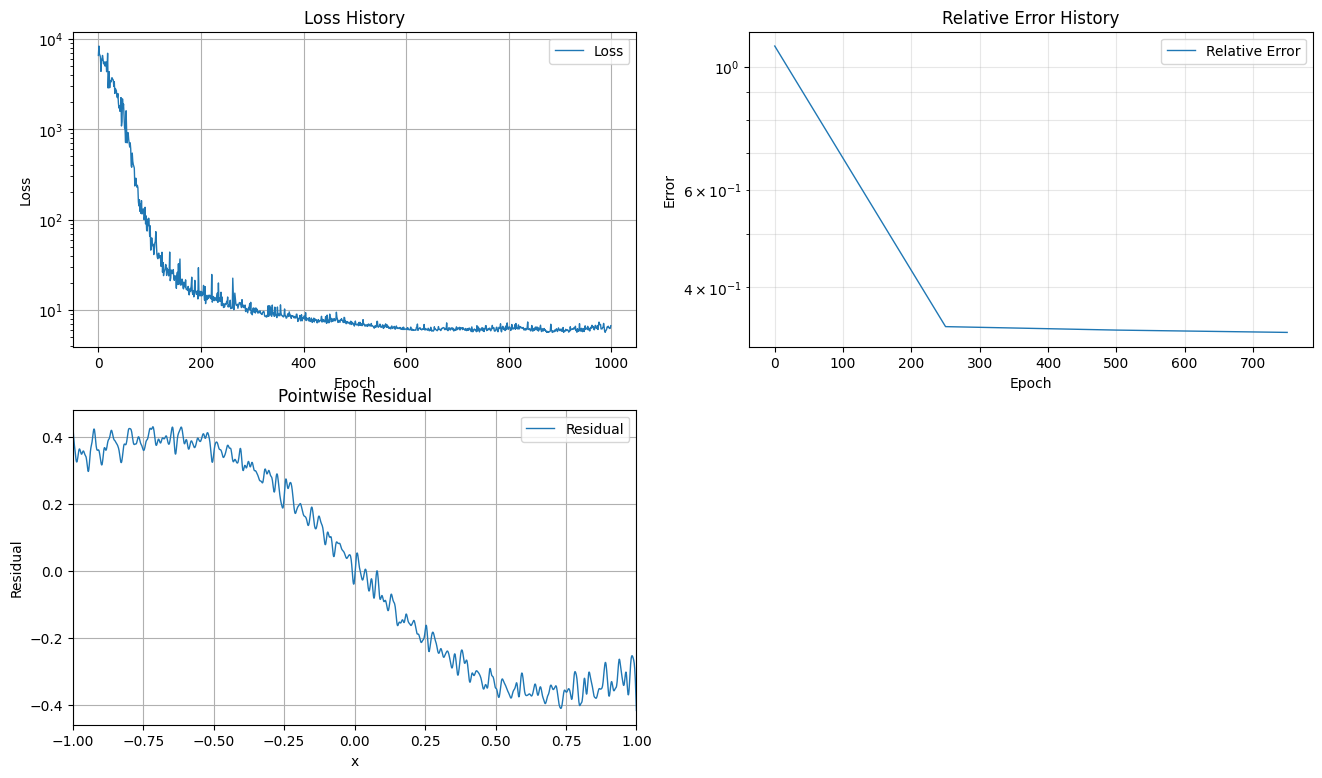

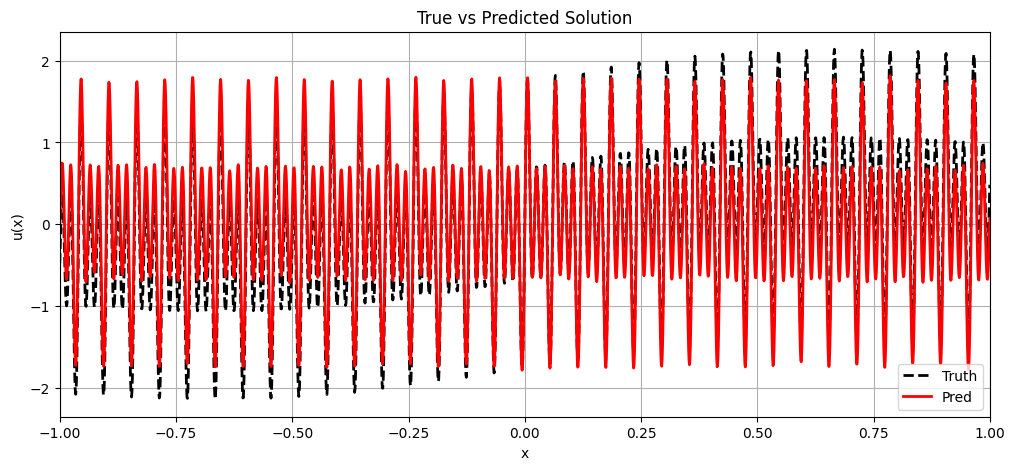

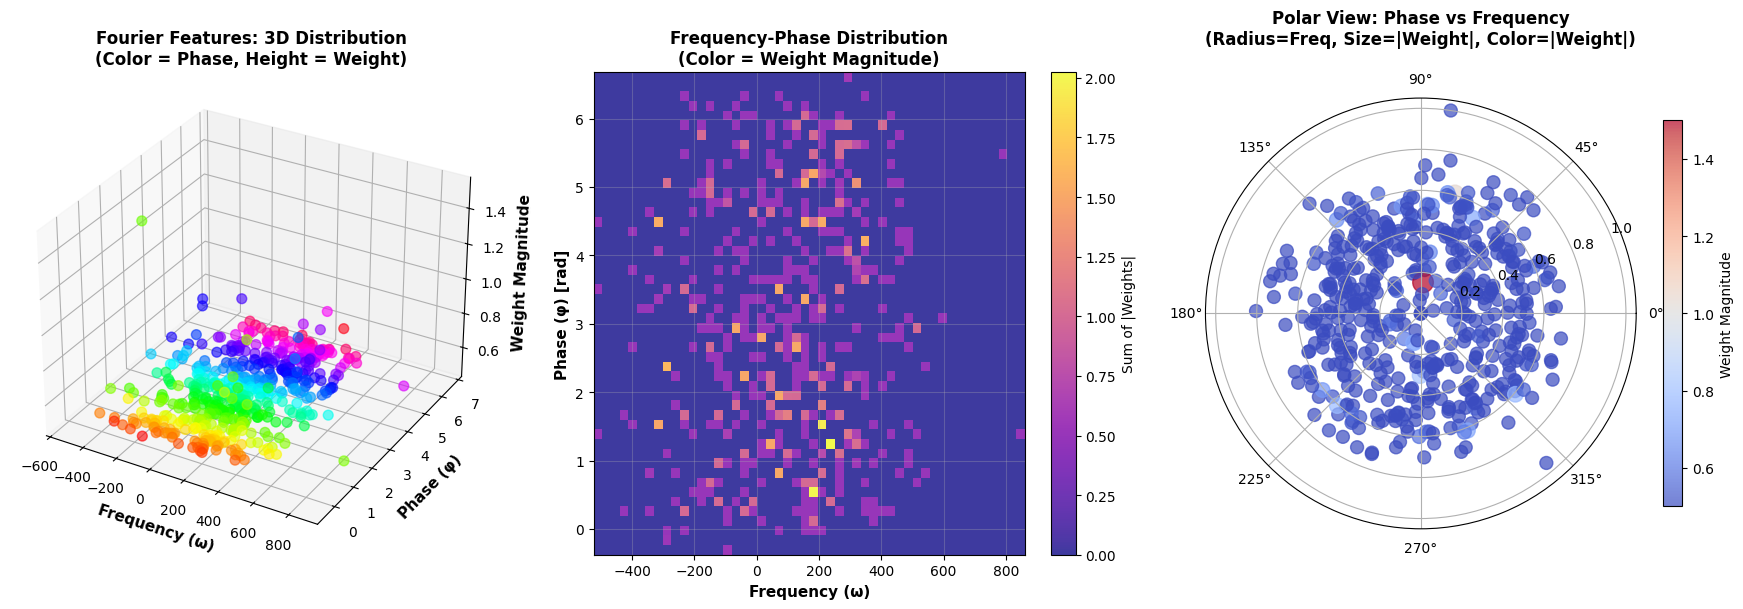

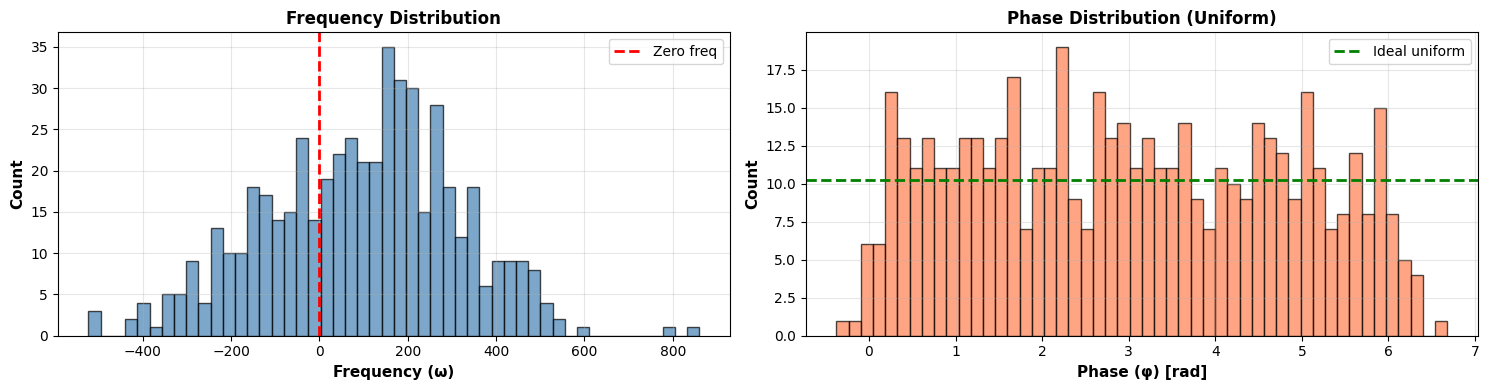

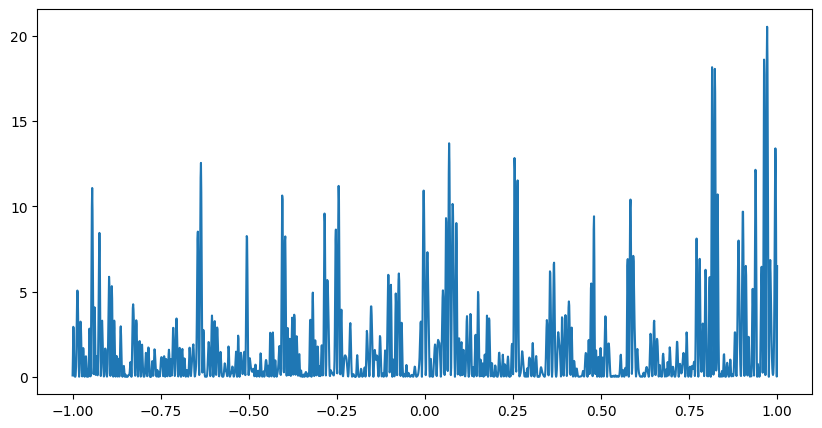

Pruning summary | Threshold: 1.00e-01 | Original features: 512 | Kept features: 16 | Sparsity: 96.9% | Max importance: 6.30e-01


In [67]:
solver1=OneDimPoissonEq(batch_size=64,feature_dim=512, fre_lb=100, fre_ub=320.0)
history=solver1.fit(nIter=1000)
pruned_network1 = solver1.prune_fourier_features(threshold=0.1)

✓ Loaded external SimpleFourierNN model (feature_dim=8)
Iter 0 |Loss_f: 2.439e+01,Loss_b:1.085e-01,Loss_l1:1.931e+00
Iter 0/1000 | Relative Error: 3.559e-01
Iter 100 |Loss_f: 3.494e-01,Loss_b:9.630e-02,Loss_l1:2.032e+00


C:\Users\hp\AppData\Local\Temp\ipykernel_2524\1521949907.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval_tensor = torch.tensor(self.x_eval).to(self.device)
C:\Users\hp\AppData\Local\Temp\ipykernel_2524\1521949907.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x).to(self.device)


Iter 200 |Loss_f: 8.512e-02,Loss_b:9.584e-02,Loss_l1:2.022e+00
Iter 250/1000 | Relative Error: 3.298e-01
Iter 300 |Loss_f: 5.340e-02,Loss_b:9.443e-02,Loss_l1:2.016e+00
Iter 400 |Loss_f: 2.615e-02,Loss_b:9.432e-02,Loss_l1:2.011e+00
Iter 500 |Loss_f: 1.905e-02,Loss_b:9.497e-02,Loss_l1:2.009e+00
Iter 500/1000 | Relative Error: 3.298e-01
Iter 600 |Loss_f: 1.228e-02,Loss_b:9.377e-02,Loss_l1:2.007e+00
Iter 700 |Loss_f: 6.101e-03,Loss_b:9.182e-02,Loss_l1:2.000e+00
Iter 750/1000 | Relative Error: 3.298e-01
Iter 800 |Loss_f: 8.165e-03,Loss_b:9.291e-02,Loss_l1:2.001e+00
Iter 900 |Loss_f: 9.240e-03,Loss_b:9.162e-02,Loss_l1:1.999e+00


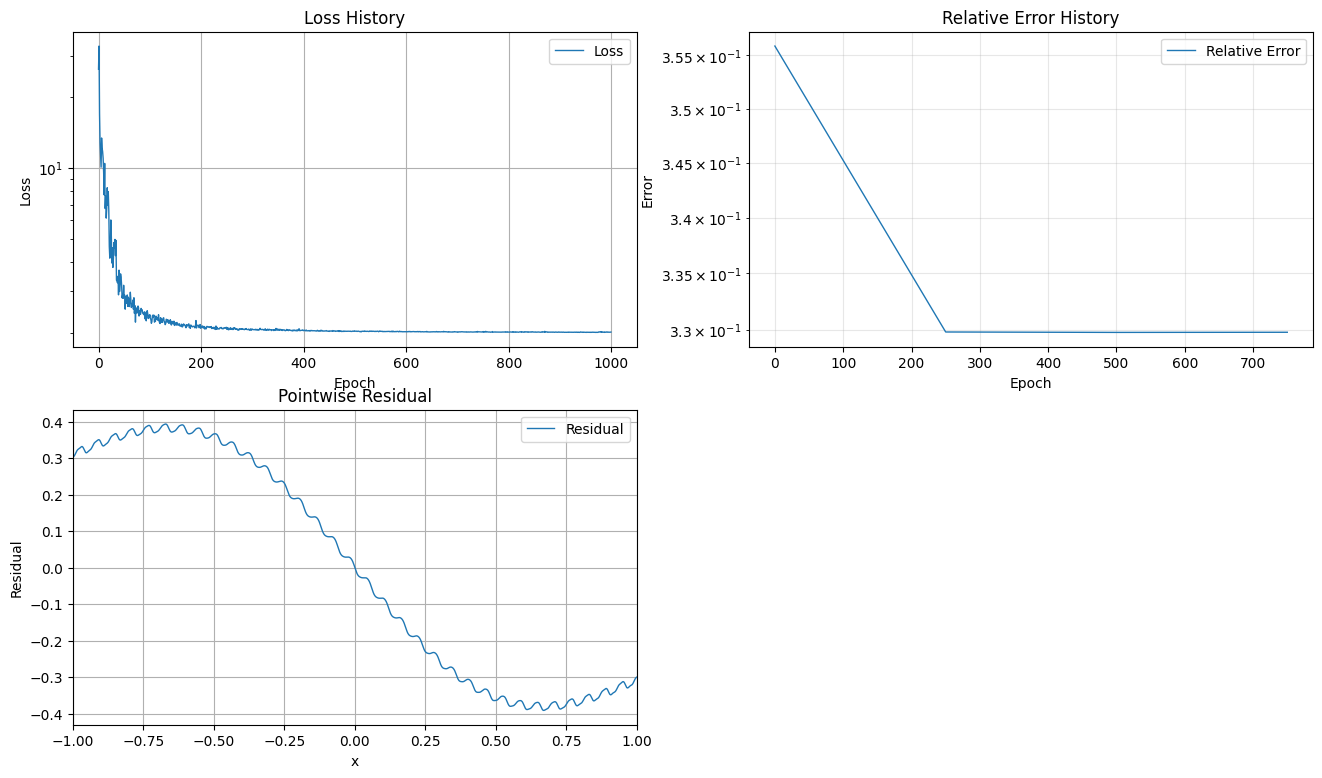

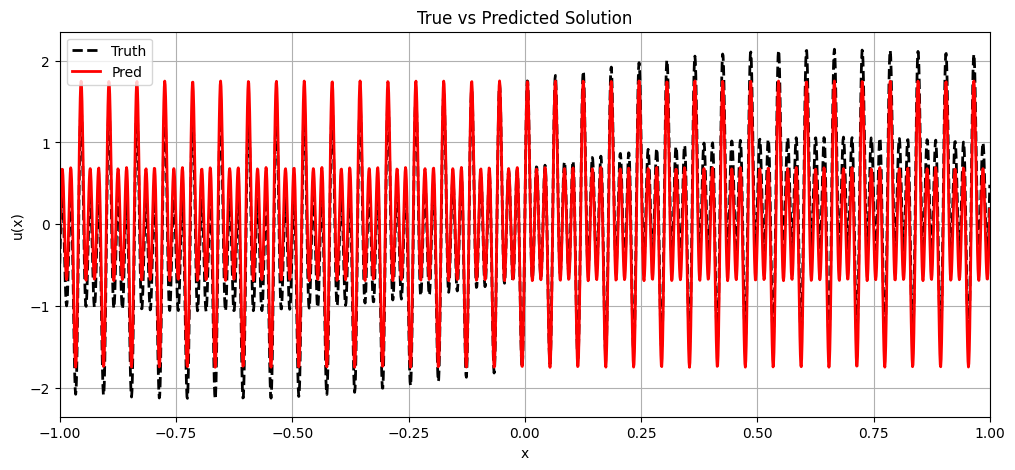

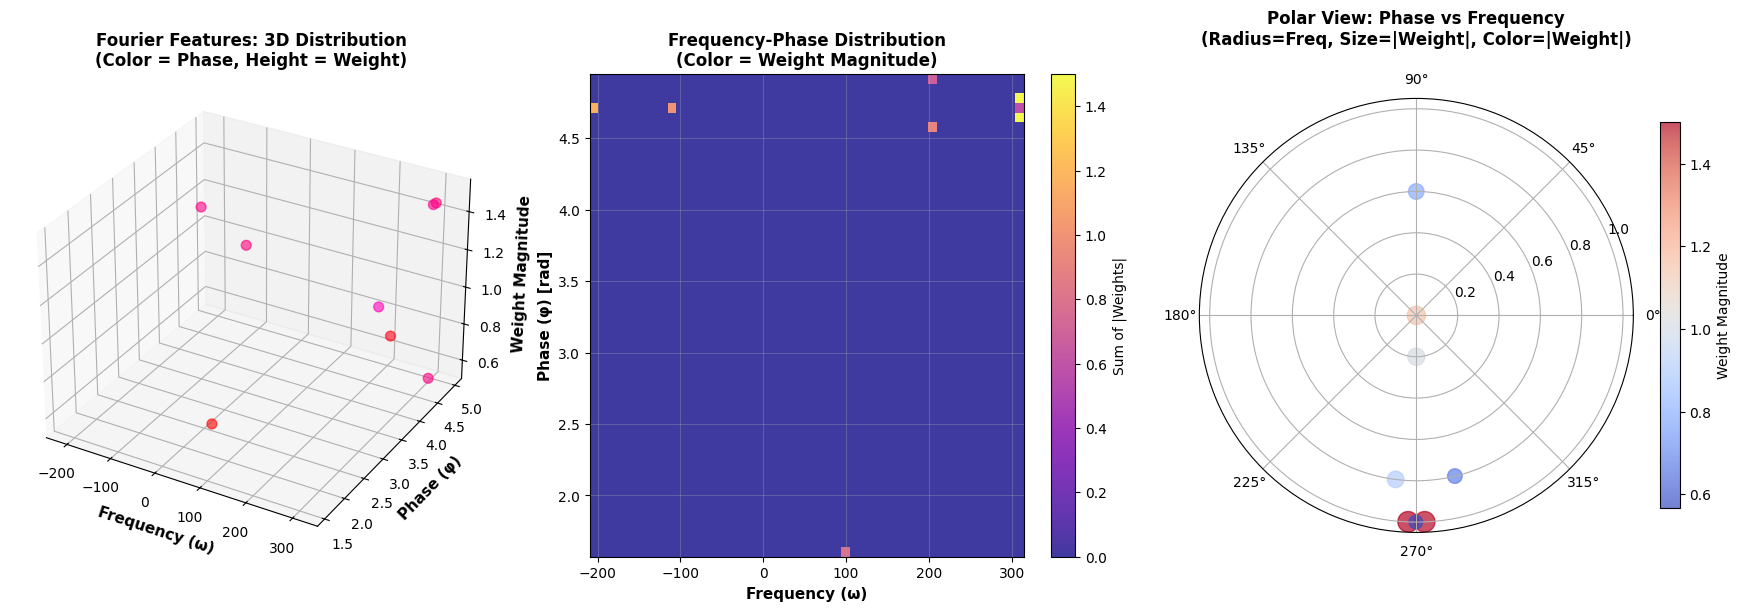

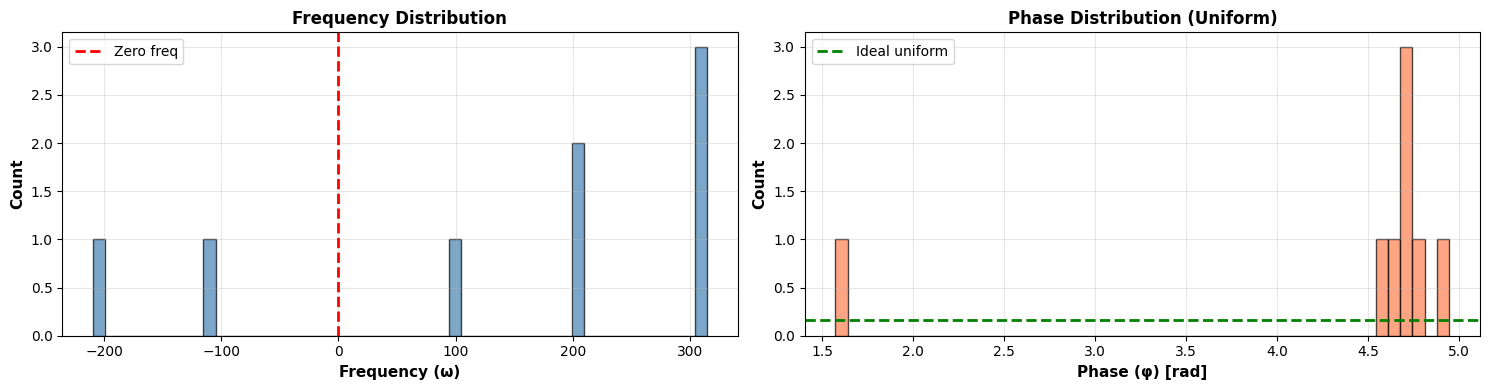

{'loss': [26.322669982910156,
  32.99188232421875,
  16.912193298339844,
  12.79620361328125,
  11.461896896362305,
  10.089653015136719,
  13.422690391540527,
  12.189666748046875,
  11.743484497070312,
  11.000103950500488,
  9.5556001663208,
  7.691749095916748,
  10.469308853149414,
  6.731321334838867,
  7.598199367523193,
  6.130037307739258,
  6.7282280921936035,
  8.250842094421387,
  6.965783596038818,
  7.948824882507324,
  6.669644355773926,
  4.647665023803711,
  4.143026351928711,
  4.39811897277832,
  6.019294738769531,
  5.097454071044922,
  3.9498214721679688,
  4.5888214111328125,
  3.7841713428497314,
  4.131585121154785,
  4.826727867126465,
  4.5599870681762695,
  4.978269577026367,
  4.24582576751709,
  4.92811393737793,
  3.3406295776367188,
  3.313966751098633,
  3.25692081451416,
  3.4717044830322266,
  2.8941569328308105,
  3.685032844543457,
  2.9893851280212402,
  3.2103826999664307,
  3.5525622367858887,
  3.440645694732666,
  3.1792025566101074,
  2.8084344

In [49]:
solver2=OneDimPoissonEq(batch_size=64, u_model=pruned_network1)
solver2.fit(nIter=1000)

In [50]:
class OneDimResPoissonEq(nn.Module):
    def __init__(self, batch_size, feature_dim, fre_lb, fre_ub, pruned_network):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.record_steps = 250
        self.lb = -1.0
        self.ub = 1.0
        self.boundary_x = torch.tensor([[self.lb], [self.ub]], device=self.device)
        self.boundary_u = torch.tensor([[u(torch.tensor(self.lb))], [u(torch.tensor(self.ub))]], device=self.device)
        self.batch_size = batch_size
        self.x_eval = torch.linspace(self.lb, self.ub, 2048).reshape(-1, 1).to(self.device)
        self.u_eval = u(self.x_eval)
        self.lb = torch.tensor(self.lb).to(self.device)
        self.ub = torch.tensor(self.ub).to(self.device)
        self.u = SimpleFourierNN(
            input_dim=1,
            feature_dim=feature_dim,
            fre_lb=fre_lb,
            fre_ub=fre_ub
        ).to(self.device)
        self.pruned_network = pruned_network.to(self.device)
        print(f"Created new SimpleFourierNN (feature_dim={feature_dim}, freq_range=[{fre_lb}, {fre_ub}])")
        fourier_params = list(self.u.rff.parameters())
        network_params = list(self.u.network.parameters())
        self.optimizer = torch.optim.Adam([
            {'params': fourier_params, 'lr': 1e-2},
            {'params': network_params, 'lr': 1e-2}
        ])
        self.history = {'loss': [], 'error': []}
            
    def diff_operator(self, x, model):
        """计算PDE残差: -u'' = f -> u'' + f = 0"""
        u = model(x) + self.pruned_network(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return - u_xx 

    def l1_regularization(self, model, l1_alpha):
        l1_loss = 0
        for name, param in model.named_parameters():
            if 'weight' in name:  # 只对权重，不包括bias
                l1_loss += torch.sum(torch.abs(param))
        return l1_alpha * l1_loss
        
    def lowpass_filter_residual_sq_1d(self, residual_sq, x, window_ratio, min_window):
        """
        对1D配置点上的残差平方场进行空间低通滤波（提取低频分量）    
        Args:
            residual_sq: [N] 或 [N,1] 张量，PDE残差平方 (即 (u_xx + f)^2)
            x: [N, 1] 张量，配置点坐标（需与residual_sq对应）
            window_ratio: 滤波窗口占批次比例（物理尺度感知）
            min_window: 最小窗口大小（避免小批次失效）
        
        Returns:
            smoothed_residual_sq: [N] 张量，低频增强后的残差平方（同输入顺序）
        """
        # =============== 安全预处理 ===============
        if residual_sq.ndim == 2:
            residual_sq = residual_sq.squeeze(1)
        if x.ndim == 2:
            x = x.squeeze(1)
        
        N = residual_sq.shape[0]
        if N <= 1:
            return residual_sq.clone()
        
        # =============== 动态窗口计算（物理尺度感知） ===============
        # 窗口物理长度 = 域长 * window_ratio → 转换为点数（基于当前批次密度）
        domain_length = x.max().detach() - x.min().detach()
        window_physical = domain_length * window_ratio
        # 估算窗口内平均点数（避免固定点数在稀疏区域失效）
        avg_density = N / domain_length
        window_size = int(window_physical * avg_density)
        window_size = max(min_window, min(window_size, N))
        if window_size % 2 == 0:
            window_size += 1  # 确保奇数窗口
        
        # =============== 排序 + 反射填充滑动平均（1D最优解） ===============
        # 关键：x.detach()用于邻域构建（邻域关系不应影响x梯度）
        sort_idx = torch.argsort(x.detach())
        x_sorted = x[sort_idx]
        res_sorted = residual_sq[sort_idx]  # 保留梯度！仅重排
        
        # 转换为卷积输入格式 [1, 1, N]
        res_reshaped = res_sorted.view(1, 1, -1)
        
        # 反射填充（缓解边界效应，比zero填充更物理）
        padding = window_size // 2
        res_padded = torch.nn.functional.pad(res_reshaped, (padding, padding), mode='reflect')
        
        # 滑动平均（等效高斯核的零阶近似，计算高效）
        smoothed_sorted = torch.nn.functional.avg_pool1d(
            res_padded, 
            kernel_size=window_size, 
            stride=1
        ).squeeze()  # 输出 [N]
        
        # =============== 恢复原始点顺序（梯度正确传递） ===============
        inv_sort_idx = torch.argsort(sort_idx)  # 逆索引：排序位置 → 原始位置
        smoothed_original = smoothed_sorted[inv_sort_idx]
        
        return smoothed_original

    def loss(self):
        x_f = torch.rand(self.batch_size, 1, device=self.device)  # [0, 1)
        x_f = (self.lb + (self.ub - self.lb) * x_f).requires_grad_() 
        
        residual = self.diff_operator(x_f, self.u) - f(x_f)
        residual_sq = residual ** 2
        residual_sq_lowfreq = self.lowpass_filter_residual_sq_1d(
            residual_sq, 
            x_f, 
            window_ratio=1.0,  
            min_window=7
        )
        loss_f = torch.mean(residual_sq_lowfreq) / 1e6          
        loss_b = torch.mean((self.u(self.boundary_x) + self.pruned_network(self.boundary_x)-self.boundary_u)**2)
        loss_l1= self.l1_regularization(self.u, l1_alpha=1.0)
        return loss_f,loss_b,loss_l1
    
    def fit(self, nIter):
        self.train()
        for i in range(nIter):
            # 计算损失 
            loss_f,loss_b,loss_l1 = self.loss()
            if i % 100 == 0:
                print(f'Iter {i} |Loss_f: {loss_f.item():.3e},Loss_b:{loss_b.item():.3e},Loss_l1:{loss_l1.item():.3e}')
            # 单步反向传播和更新
            loss = loss_f + 1e-2*loss_b + loss_l1
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
           
            # 计算相对误差 
            self.history['loss'].append(loss.item())
            if i % self.record_steps == 0:
                self.eval()
                x_eval_tensor = torch.tensor(self.x_eval).to(self.device)
                u_pred = self.predict(x_eval_tensor)
                error = np.linalg.norm(u_pred -self.u_eval.detach().cpu().numpy()) / np.linalg.norm(self.u_eval.detach().cpu().numpy())
                self.history['error'].append(error)
                print(f'Iter {i}/{nIter} | Relative Error: {error:.3e}')
                self.train()            
        self.plot()
        return self.history
        
    def predict(self, x):
        """预测结果"""
        x_tensor = torch.tensor(x).to(self.device)
        with torch.no_grad():
            u_pred = self.u(x_tensor) + self.pruned_network(x_tensor)
        return u_pred.cpu().numpy() 
    
    def plot(self):
        """绘制预测结果和相对误差历史"""
        plt.figure(figsize=(16,9))
        plt.subplot(2, 2, 2)
        epochs = range(0, len(self.history['error'])*self.record_steps, self.record_steps)
        plt.semilogy(epochs, self.history['error'], linewidth=1, label='Relative Error')
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.title('Relative Error History')
        plt.grid(True, which="both", ls="-", alpha=0.3)
        plt.legend()
        
        plt.subplot(2,2,1)
        plt.semilogy(range(len(self.history['loss'])), self.history['loss'], linewidth=1, label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss History')
        plt.grid(True)
        plt.legend()

        
        plt.subplot(2, 2, 3)
        residual = self.predict(self.x_eval) - self.u_eval.detach().cpu().numpy()
        plt.plot(self.x_eval, residual, linewidth=1, label='Residual')
        plt.xlabel('x')
        plt.ylabel('Residual')
        plt.title('Pointwise Residual')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()

        # 2. 绘制真实解与预测解对比
        u_pred = self.predict(self.x_eval)
        plt.figure(figsize=(12, 5))
        plt.plot(self.x_eval, self.u_eval, 'k--', linewidth=2, label='Truth')
        plt.plot(self.x_eval, u_pred, 'r-', linewidth=2, label='Pred')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title('True vs Predicted Solution')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()

        u_res = self.u_eval - self.pruned_network(self.x_eval).detach().cpu().numpy()
        u_pred = self.predict(self.x_eval) - self.pruned_network(self.x_eval).detach().cpu().numpy()
        plt.figure(figsize=(12, 5))
        plt.plot(self.x_eval, u_res, 'k--', linewidth=2, label='Truth')
        plt.plot(self.x_eval, u_pred, 'r-', linewidth=2, label='Pred')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title('True vs Predicted Solution')
        plt.legend()
        plt.grid(True)
        plt.xlim(-1, 1)
        plt.show()          

        rff_layer = self.u.rff
        omega = rff_layer.omega.detach().cpu().numpy().flatten()  # 频率 (feature_dim,)
        phases = rff_layer.phases.detach().cpu().numpy()  # 相位 (feature_dim,)
        
        # 使用第一层网络的权重作为幅度（替代amplitude参数）
        # network[0] 是 Linear(feature_dim, width)
        first_layer_weights = self.u.network[0].weight.detach().cpu().numpy()  # shape: (width, feature_dim)
        # 计算每个特征的重要性：可以用权重的L2范数或绝对值和
        amplitudes = np.abs(first_layer_weights).sum(axis=0)  # 对输出维度求和，shape: (feature_dim,)
        # 或者使用L2范数：amplitudes = np.linalg.norm(first_layer_weights, axis=0)
        # 归一化到合理范围以便可视化
        amplitudes = amplitudes / amplitudes.max() + 0.5  # 最小0.5，最大1.5，便于观察差异
        # 创建图形
        fig = plt.figure(figsize=(18, 6))
        
        # 1. 3D散点图：频率-相位-幅度
        ax1 = fig.add_subplot(131, projection='3d')
        # 使用相位作为颜色映射
        norm = Normalize(vmin=phases.min(), vmax=phases.max())
        colors = cm.hsv(norm(phases))  # 使用HSV色彩空间，适合周期性相位
        
        scatter = ax1.scatter(omega, phases, amplitudes, c=colors, s=50, alpha=0.6, depthshade=True)
        ax1.set_xlabel('Frequency (ω)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Phase (φ)', fontsize=11, fontweight='bold')
        ax1.set_zlabel('Weight Magnitude', fontsize=11, fontweight='bold')
        ax1.set_title('Fourier Features: 3D Distribution\n(Color = Phase, Height = Weight)', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # 2. 2D直方图/热力图：频率-相位分布（幅度用颜色表示）
        ax2 = fig.add_subplot(132)
        # 创建2D直方图，用幅度作为权重
        h = ax2.hist2d(omega, phases, bins=50, weights=amplitudes, cmap='plasma', alpha=0.8)
        plt.colorbar(h[3], ax=ax2, label='Sum of |Weights|')
        ax2.set_xlabel('Frequency (ω)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Phase (φ) [rad]', fontsize=11, fontweight='bold')
        ax2.set_title('Frequency-Phase Distribution\n(Color = Weight Magnitude)', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # 3. 极坐标图：相位-幅度关系（频率作为径向距离）
        ax3 = fig.add_subplot(133, projection='polar')
        # 归一化频率用于径向显示
        freq_norm = (omega - omega.min()) / (omega.max() - omega.min() + 1e-8)
        # 使用散点图：角度=相位，半径=归一化频率，大小=幅度
        sizes = (amplitudes / amplitudes.max()) * 200 + 20  # 缩放幅度为点大小
        scatter_polar = ax3.scatter(phases, freq_norm, c=amplitudes, s=sizes, cmap='coolwarm', alpha=0.7)
        ax3.set_title('Polar View: Phase vs Frequency\n(Radius=Freq, Size=|Weight|, Color=|Weight|)', 
                     fontsize=12, fontweight='bold', pad=20)
        plt.colorbar(scatter_polar, ax=ax3, label='Weight Magnitude', shrink=0.8)
        
        plt.tight_layout()
        plt.show()
        
        # 额外的：频率分布直方图（一维）
        fig2, axes = plt.subplots(1, 2, figsize=(15, 4))
        
        # 频率分布
        axes[0].hist(omega, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[0].set_xlabel('Frequency (ω)', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
        axes[0].set_title('Frequency Distribution', fontsize=12, fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero freq')
        axes[0].legend()
        
        # 相位分布（应该是均匀的）
        axes[1].hist(phases, bins=50, color='coral', alpha=0.7, edgecolor='black')
        axes[1].set_xlabel('Phase (φ) [rad]', fontsize=11, fontweight='bold')
        axes[1].set_ylabel('Count', fontsize=11, fontweight='bold')
        axes[1].set_title('Phase Distribution (Uniform)', fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        axes[1].axhline(y=len(phases)/50, color='green', linestyle='--', linewidth=2, label='Ideal uniform')
        axes[1].legend()
        plt.tight_layout()
        plt.show()
    def prune_fourier_features(self, threshold):
        device = next(self.u.parameters()).device
        orig_rff = self.u.rff
        orig_net = self.u.network
        W1 = orig_net[0].weight.data  # shape: [1, feature_dim]
        b1 = orig_net[0].bias.data    # shape: [1]
        
        # 正确计算每个输入特征通道的重要性（沿输出维度求和）
        importance = torch.abs(W1).sum(dim=0)  # shape: [feature_dim]，避免squeeze在feature_dim=1时退化为标量
        
        keep_mask = importance >= threshold
        kept_indices = torch.nonzero(keep_mask, as_tuple=True)[0]
        if len(kept_indices) == 0:
            raise ValueError(f"Threshold {threshold:.2e} too high: all features would be pruned! "
                        f"Max importance: {importance.max().item():.2e}")
        
        sparsity_ratio = 1.0 - len(kept_indices) / len(importance)
        print(f"Pruning summary | Threshold: {threshold:.2e} | "
            f"Original features: {len(importance)} | "
            f"Kept features: {len(kept_indices)} | "
            f"Sparsity: {sparsity_ratio:.1%} | "
            f"Max importance: {importance.max().item():.2e}")
        
        new_feature_dim = len(kept_indices)
        pruned_model = SimpleFourierNN(
            input_dim=1,
            feature_dim=new_feature_dim,
            fre_lb=-1.0,
            fre_ub=1.0
        ).to(device)
        
        pruned_model.rff.omega.data = orig_rff.omega.data[kept_indices].clone()
        pruned_model.rff.phases.data = orig_rff.phases.data[kept_indices].clone()
        
        pruned_model.network[0].weight.data = W1[:, kept_indices].clone()  # shape: [1, new_feature_dim]
        pruned_model.network[0].bias.data = b1.clone()
        
        return pruned_model

Created new SimpleFourierNN (feature_dim=512, freq_range=[100, 300])
Iter 0 |Loss_f: 9.637e+02,Loss_b:1.192e-02,Loss_l1:1.163e+01
Iter 0/1000 | Relative Error: 5.502e-01


C:\Users\hp\AppData\Local\Temp\ipykernel_2524\1516509841.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_eval_tensor = torch.tensor(self.x_eval).to(self.device)
C:\Users\hp\AppData\Local\Temp\ipykernel_2524\1516509841.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x).to(self.device)


Iter 100 |Loss_f: 6.483e-02,Loss_b:9.144e-02,Loss_l1:5.546e-01
Iter 200 |Loss_f: 1.445e-02,Loss_b:8.839e-02,Loss_l1:2.155e-01
Iter 250/1000 | Relative Error: 3.307e-01
Iter 300 |Loss_f: 1.472e-02,Loss_b:1.027e-01,Loss_l1:2.197e-01
Iter 400 |Loss_f: 2.318e-02,Loss_b:8.973e-02,Loss_l1:2.360e-01
Iter 500 |Loss_f: 2.859e-02,Loss_b:8.594e-02,Loss_l1:2.563e-01
Iter 500/1000 | Relative Error: 3.284e-01
Iter 600 |Loss_f: 3.695e-02,Loss_b:8.636e-02,Loss_l1:2.889e-01
Iter 700 |Loss_f: 9.032e-02,Loss_b:9.226e-02,Loss_l1:2.803e-01
Iter 750/1000 | Relative Error: 3.278e-01
Iter 800 |Loss_f: 6.561e-02,Loss_b:9.448e-02,Loss_l1:3.100e-01
Iter 900 |Loss_f: 1.071e-01,Loss_b:8.859e-02,Loss_l1:3.257e-01


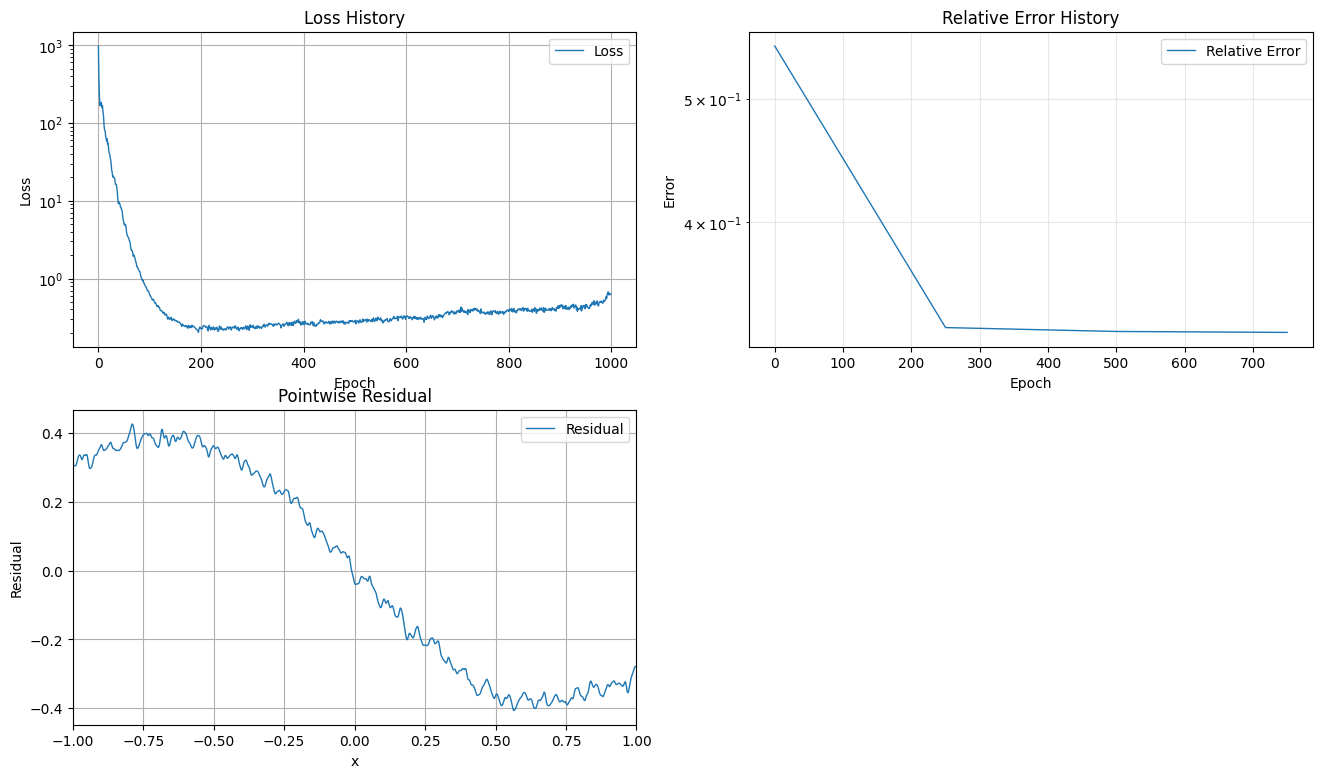

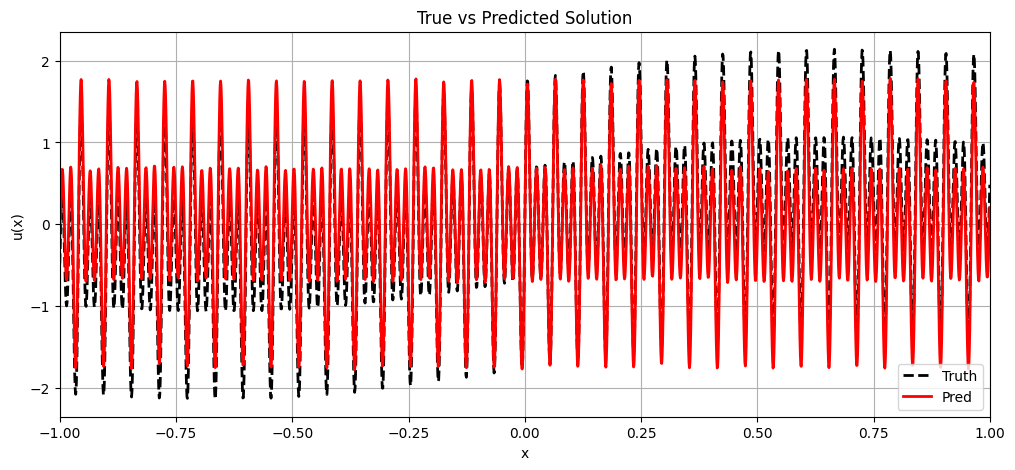

C:\Users\hp\AppData\Local\Temp\ipykernel_2524\1516509841.py:199: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  u_res = self.u_eval - self.pruned_network(self.x_eval).detach().cpu().numpy()


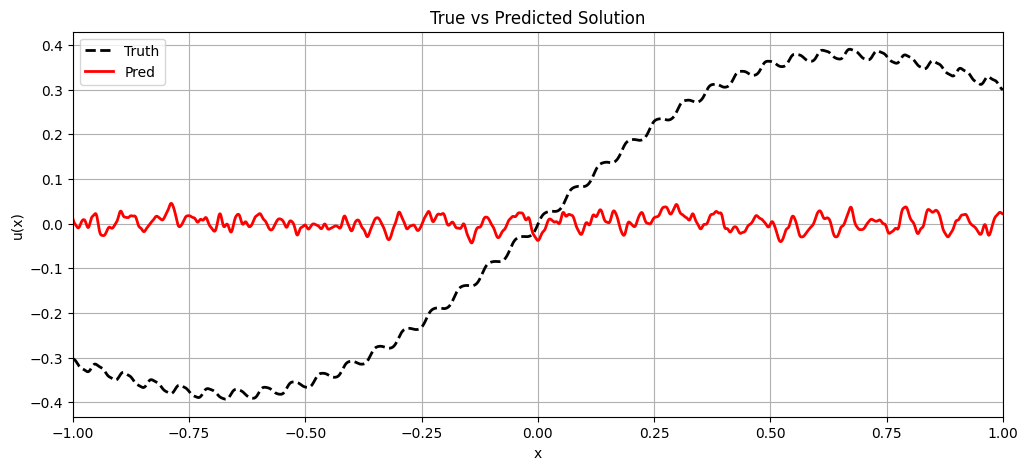

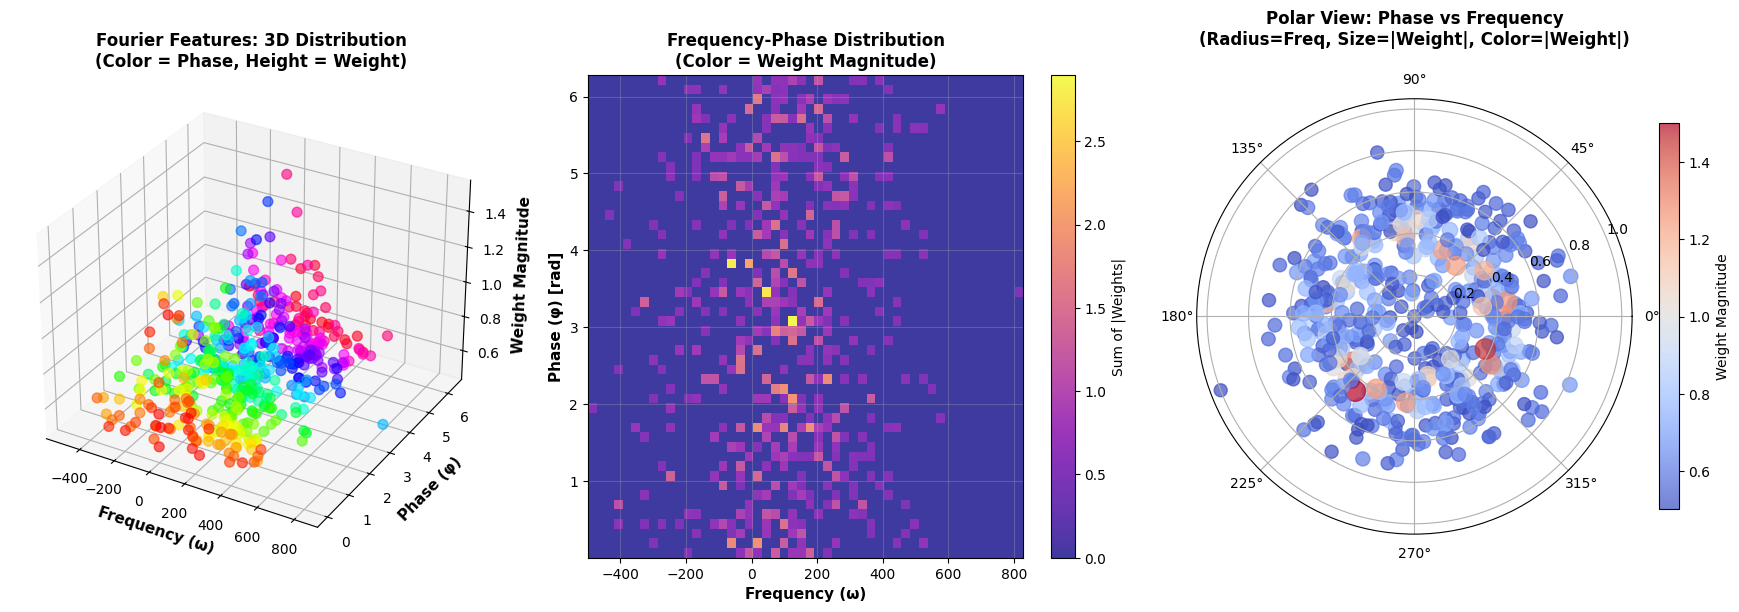

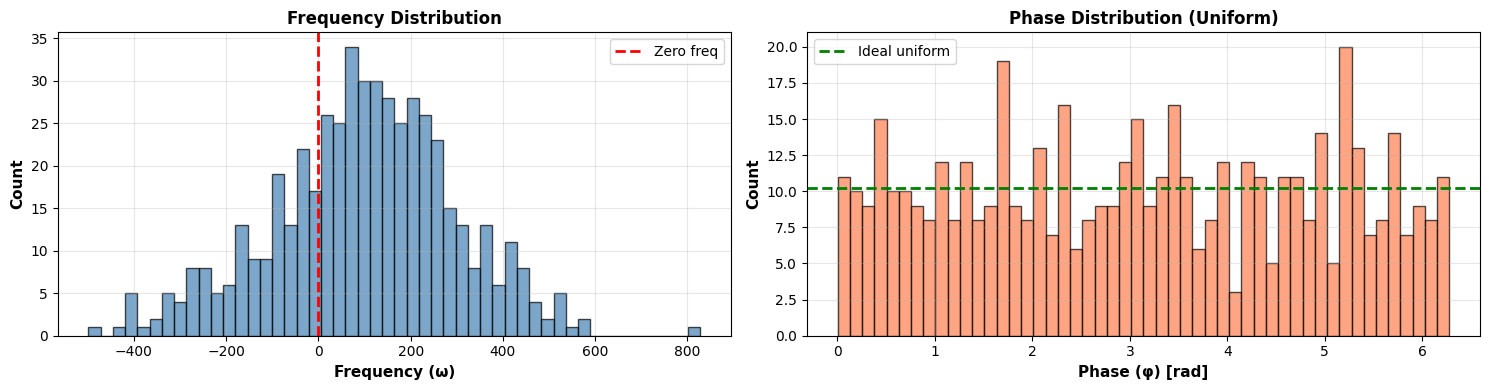

{'loss': [975.3154907226562,
  382.729248046875,
  221.02117919921875,
  166.80828857421875,
  177.8614501953125,
  184.24205017089844,
  178.52420043945312,
  157.45111083984375,
  165.7431182861328,
  136.8695068359375,
  123.27140045166016,
  93.48526763916016,
  81.50369262695312,
  79.75907897949219,
  68.93598937988281,
  63.998416900634766,
  58.49540710449219,
  62.719757080078125,
  53.38594055175781,
  54.91397476196289,
  45.4959602355957,
  41.228790283203125,
  40.01277160644531,
  35.74365997314453,
  33.44139862060547,
  29.246158599853516,
  24.450620651245117,
  22.926103591918945,
  20.18644142150879,
  20.777530670166016,
  19.951148986816406,
  19.731586456298828,
  19.069074630737305,
  16.347253799438477,
  16.317495346069336,
  16.17285919189453,
  14.637928009033203,
  12.618303298950195,
  10.314488410949707,
  9.160978317260742,
  9.649938583374023,
  9.469321250915527,
  8.993148803710938,
  8.305829048156738,
  8.228841781616211,
  7.7172465324401855,
  7.60

In [51]:
solver3 = OneDimResPoissonEq(batch_size=1024,feature_dim=512, fre_lb=100, fre_ub=300,pruned_network=solver2.u)
solver3.fit(nIter=1000)

In [44]:
pruned_network2 = solver3.prune_fourier_features(threshold=0.03)
solver4 = OneDimPoissonEq(batch_size=64, u_model=pruned_network2)


Pruning summary | Threshold: 3.00e-02 | Original features: 512 | Kept features: 1 | Sparsity: 99.8% | Max importance: 3.56e-02
✓ Loaded external SimpleFourierNN model (feature_dim=1)


C:\Users\hp\AppData\Local\Temp\ipykernel_2524\4007518492.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x).to(self.device)


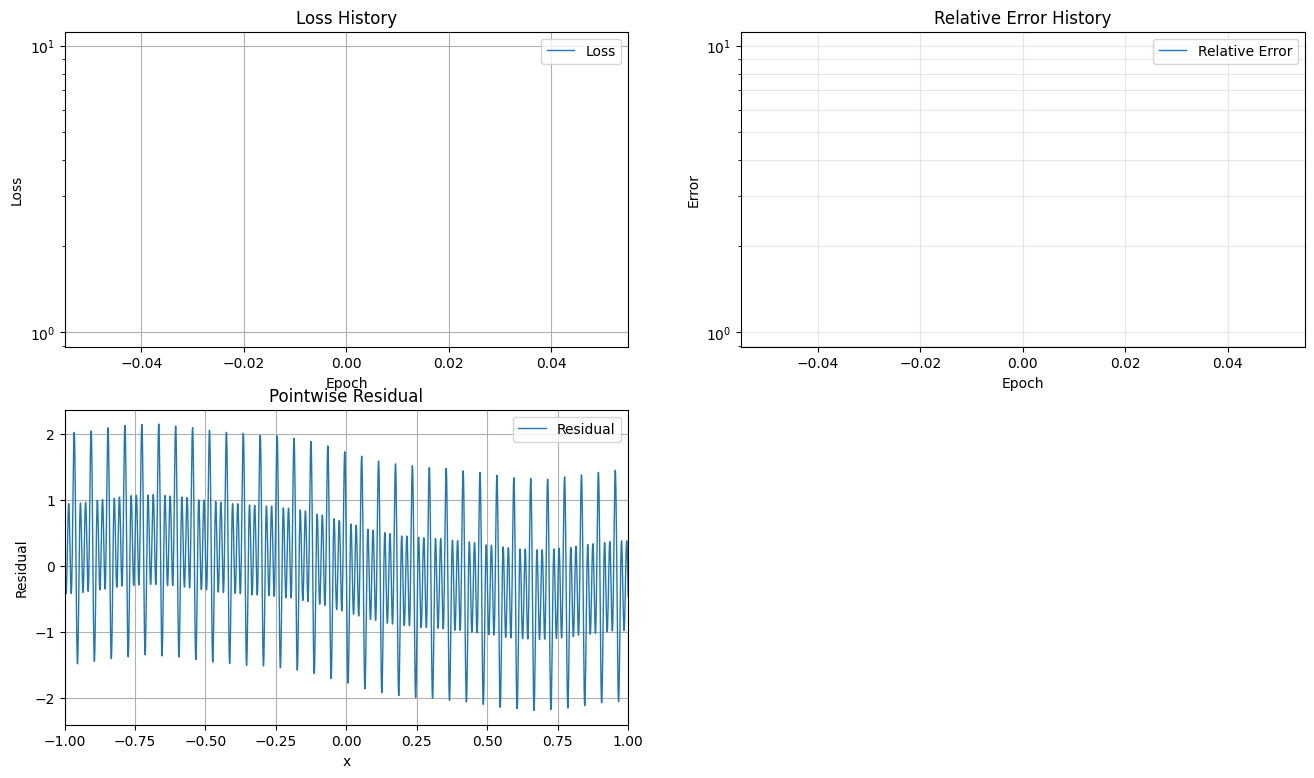

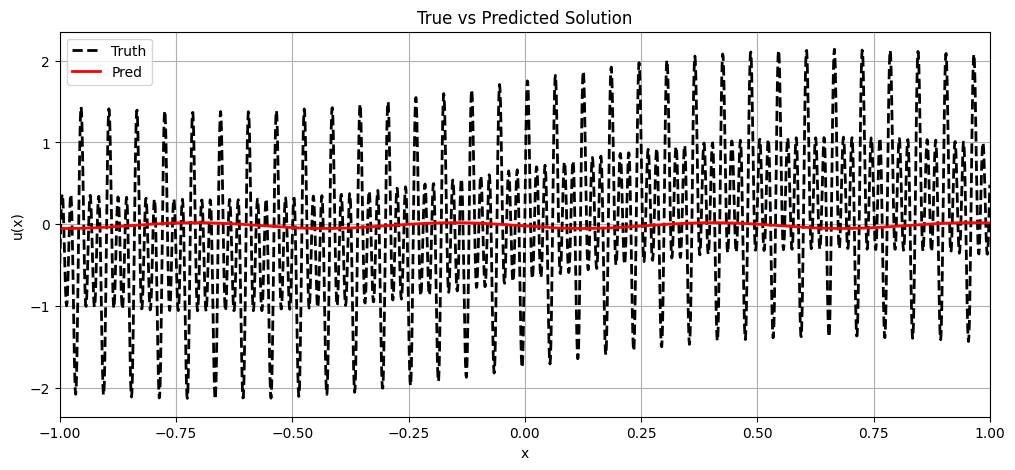

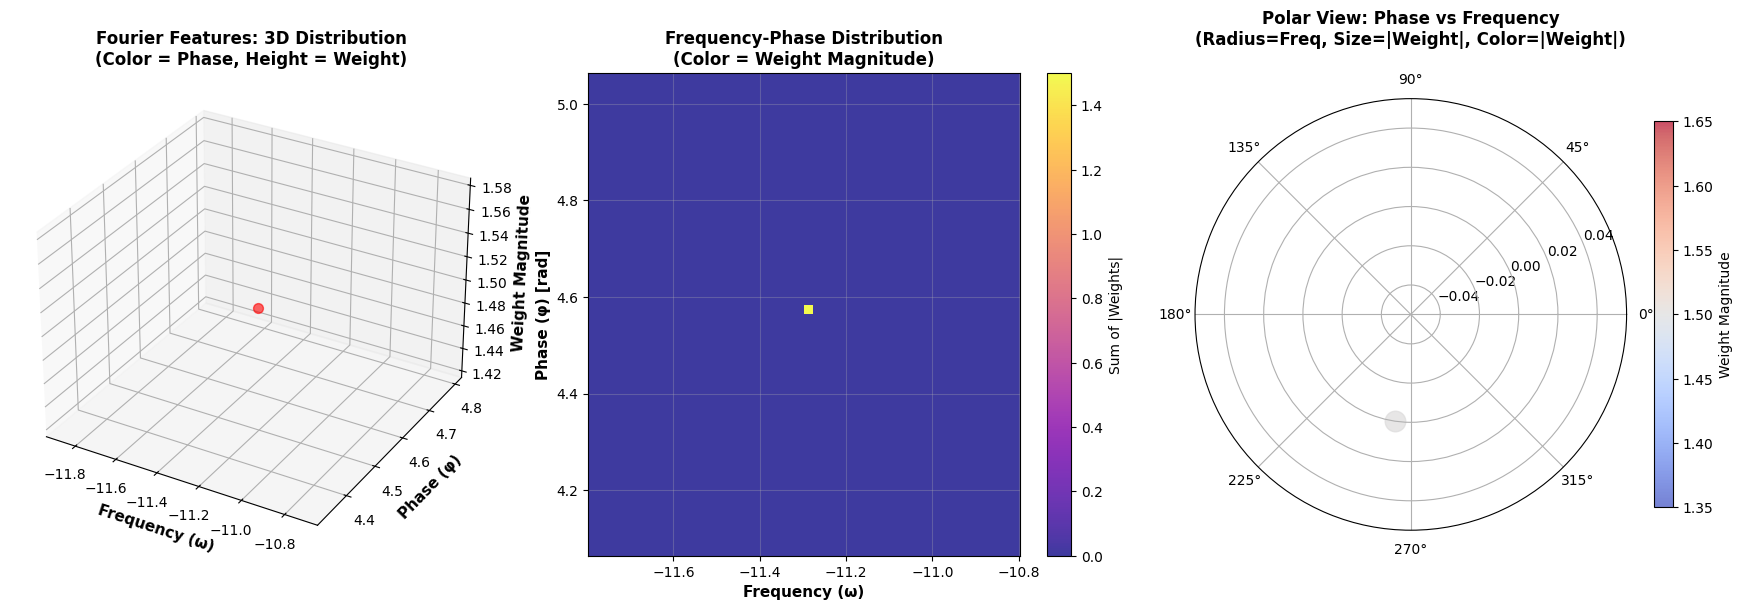

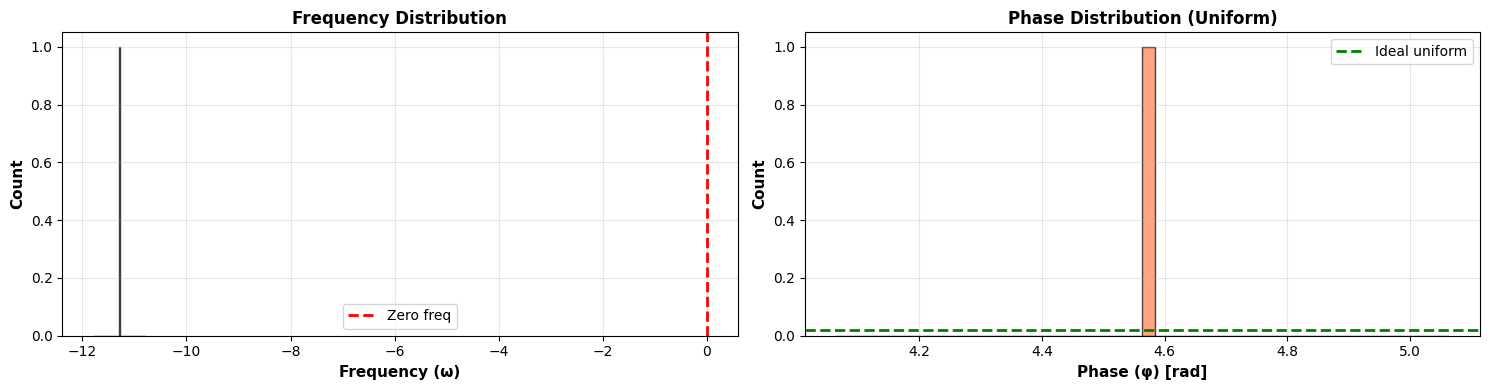

{'loss': [], 'error': []}

In [45]:
solver4.fit(nIter=0)

Pruning summary | Threshold: 4.00e-03 | Original features: 512 | Kept features: 11 | Sparsity: 97.9% | Max importance: 6.03e-03
✓ Loaded external SimpleFourierNN model (feature_dim=11)


C:\Users\hp\AppData\Local\Temp\ipykernel_20412\4007518492.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x).to(self.device)


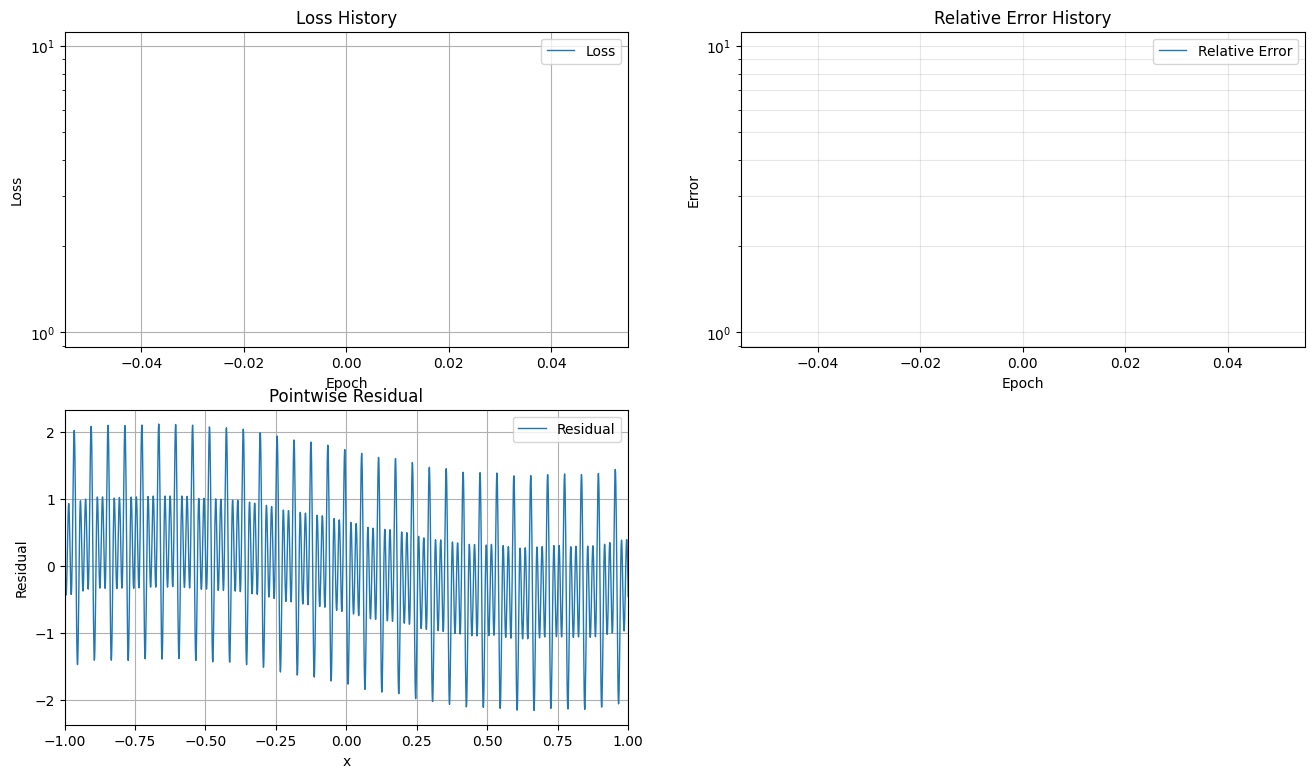

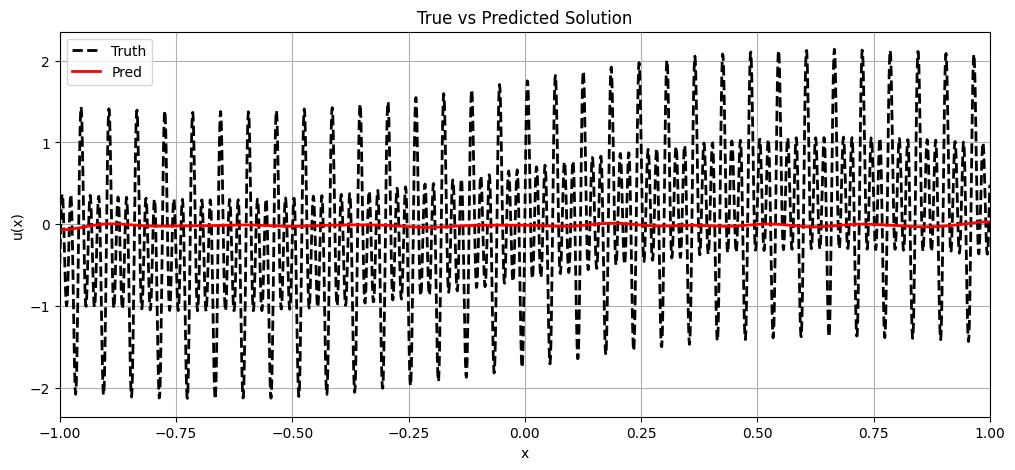

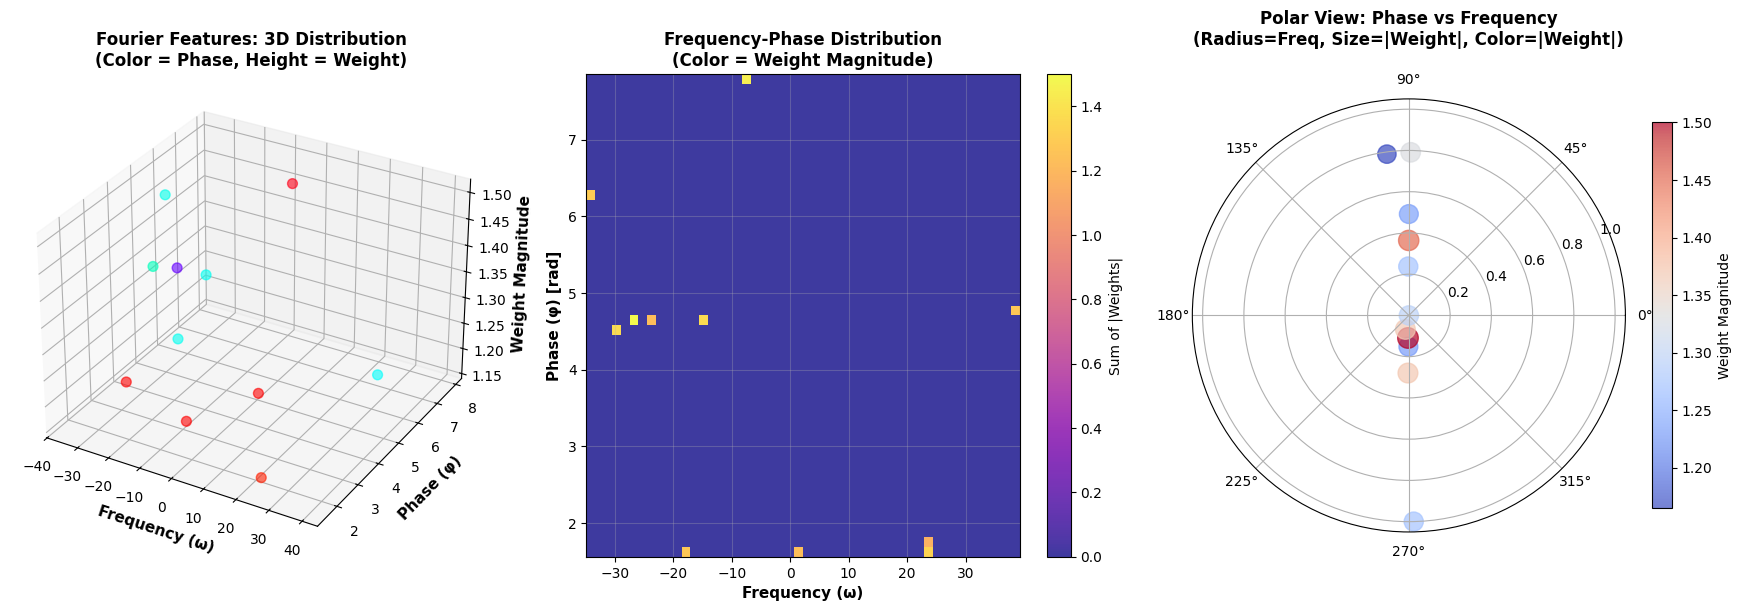

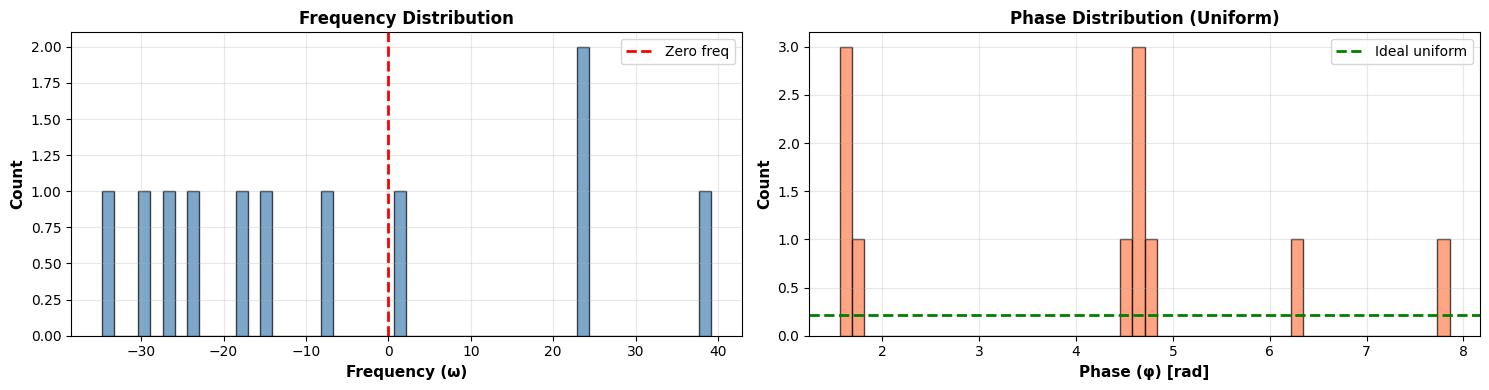

{'loss': [], 'error': []}

In [ ]:
pruned_network2 = solver3.prune_fourier_features(threshold=0.004)
pruned_solver=OneDimPoissonEq(batch_size=64, u_model=pruned_network2)
pruned_solver.fit(nIter=0)